In [ ]:

!apt-get install -y coinor-libcoinutils3v5 coinor-libosi1v5 libsuitesparseconfig5
!apt-get install -y coinor-libipopt1v5
!apt-get install -y coin-or-cbc
!wget -N -q "https://ampl.com/dl/open/bonmin/bonmin-linux64.zip"
!unzip -o -q bonmin-linux64
!apt-get install -y coinor-cbc coinor-cgl coinor-libcoinutils3 coinor-libosi3 coinor-clp
!apt-get install -y coinor-libbonmin1




In [ ]:
from amplpy import modules
import gurobipy as gp
import pyomo.environ as py
import random as rd
import math

In [ ]:

num_of_trips = 14



trip_start_times = {
                    1:5.00,
                    2:6.50,
                    3:7.00,
                    4:8.50,
                    5:9.00,
                    6:10.50,
                    7:11.0,
                    8:13.50,
                    9:13.50,
                    10:15.50,
                    11:16.00,
                    12:17.50,
                    13:18.00,
                    14:19.00}



trip_end_times = {
                    1:6.00,
                    2:8.0,
                    3:8.50,
                    4:10.00,
                    5:10.25,
                    6:12.00,
                    7:12.30,
                    8:14.75,
                    9:15.00,
                    10:17.00,
                    11:17.50,
                    12:19.00,
                    13:19.30,
                    14:20.30}



for i in trip_end_times:
  trip_end_times[i] = round(trip_end_times[i]*60)

for i in trip_start_times:
  trip_start_times[i] = round(trip_start_times[i]*60)

trip_times = {}
for i in range(1,num_of_trips + 1):
    trip_times[i] = trip_end_times[i] - trip_start_times[i]


gamma_1 = -0.000409
gamma_2 = -2.167
gamma_3 = 0.00001408
gamma_4 = 6.13


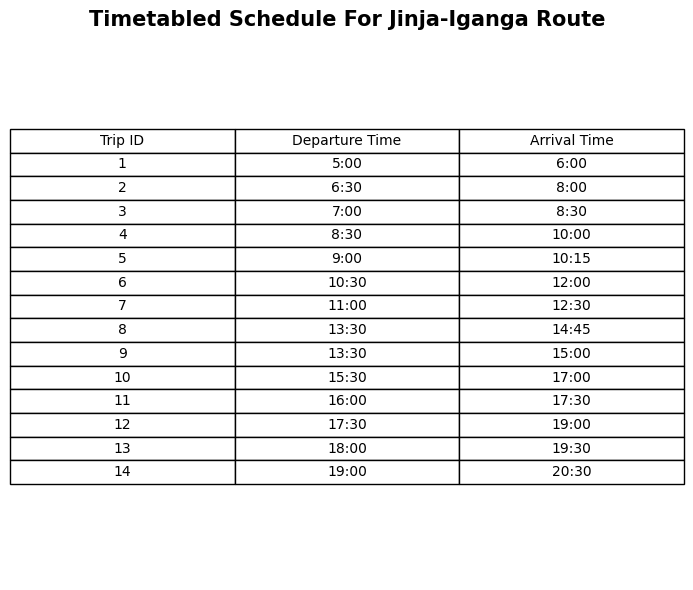

In [ ]:
import matplotlib.pyplot as plt

# Sample data
trip_ids = list(range(1, 15))
trip_start = [
    "5:00", "6:30", "7:00", "8:30", "9:00", "10:30", "11:00",
    "13:30", "13:30", "15:30", "16:00", "17:30", "18:00", "19:00"
]
trip_end = [
    "6:00", "8:00", "8:30", "10:00", "10:15", "12:00", "12:30",
    "14:45", "15:00", "17:00", "17:30", "19:00", "19:30", "20:30"
]



# Prepare table data
columns = ["Trip ID", "Departure Time", "Arrival Time"]
cell_data = list(zip(trip_ids, trip_start, trip_end))

# Plot the table
fig, ax = plt.subplots(figsize=(7, 6))
ax.axis('off')  # Hide axis

table = ax.table(cellText=cell_data, colLabels=columns, loc='center', cellLoc='center')

# Style
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.title("Timetabled Schedule For Jinja-Iganga Route", fontsize=15, weight='bold', pad=5)
plt.tight_layout()
plt.show()

In [ ]:
import os
from dotenv import load_dotenv

# Load variables from .env file
load_dotenv()

# Update Gurobi params
params = {
    "WLSACCESSID": os.getenv("GUROBI_WLSACCESSID"),
    "WLSSECRET": os.getenv("GUROBI_WLSSECRET"),
    "LICENSEID": int(os.getenv("GUROBI_LICENSEID")), # License ID must be an integer
}
env = gp.Env(params=params)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2634553
Academic license 2634553 - for non-commercial use only - registered to sa___@students.mak.ac.ug


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from amplpy import AMPL, ampl_notebook
from dotenv import load_dotenv
import os
load_dotenv()

ampl = ampl_notebook(
    modules=["highs", "cbc", "gurobi", "cplex","baron", "coin","snopt","minos"], # pick from over 20 modules including most commercial and open-source solvers
    license_uuid=os.getenv("AMPL_LICENSE_UUID")) # your license UUID (e.g., free ampl.com/ce or ampl.com/courses licenses)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib
from datetime import datetime, timedelta
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR

class EVEnergyPredictor:
    def __init__(self, data_path):
        self.data_path = data_path
        self.model = None
        self.scaler = MinMaxScaler()
        self.feature_columns = None
        self.categorical_mappings = {
            'Terrain_Type': ['hilly', 'non-hilly'],
            'Traffic': ['no traffic', 'present traffic']
        }


    def predict(self, input_data):
        """Predict energy consumption with non-linear features"""
        if self.model is None:
            raise ValueError("Model not trained yet. Call train_model() first.")

        # Create template with all expected base feature columns
        base_features = {}
        for num_feat in self.base_numeric_features:
            if num_feat in input_data:
                base_features[num_feat] = input_data[num_feat]
            else:
                # Use historical median if not provided
                base_features[num_feat] = self.feature_medians[num_feat]

        # Add categorical features
        if 'Terrain_Type' in input_data:
            base_features['Terrain_Type'] = 1 if str(input_data['Terrain_Type']).lower() in ['hilly', '1'] else 0
        else:
            base_features['Terrain_Type'] = 0  # Default to non-hilly

        if 'Traffic' in input_data:
            base_features['Traffic'] = 1 if str(input_data['Traffic']).lower() in ['present traffic', '1'] else 0
        else:
            base_features['Traffic'] = 0  # Default to no traffic

        # Create derived features
        derived_features = {
            'Distance_Squared': base_features['Distance_km'] ** 2,
            'Speed_Squared': base_features['Average_Speed'] ** 2,
            'Distance_Speed': base_features['Distance_km'] * base_features['Average_Speed'],
            'Distance_Terrain': base_features['Distance_km'] * base_features['Terrain_Type'],
            'Speed_Terrain': base_features['Average_Speed'] * base_features['Terrain_Type'],
            'Passengers_Distance': base_features['Passengers'] * base_features['Distance_km']
        }

        # Combine all features
        all_features = {**base_features, **derived_features}

        # Create DataFrame with features in the correct order
        template = pd.DataFrame(columns=self.feature_columns)
        for feature in self.feature_columns:
            template[feature] = [all_features[feature]]

        # Normalize only numeric features
        if len(self.numeric_features) > 0:
            template[self.numeric_features] = self.scaler.transform(template[self.numeric_features])

        # Predict and ensure reasonable values
        prediction = max(self.model.predict(template)[0], 0.1)
        return min(prediction, 100)  # Cap predictions at 100 kWh


    @classmethod
    def load_model(cls, path):
        """Load a saved model"""
        components = joblib.load(path)
        predictor = cls(None)
        predictor.model = components['model']
        predictor.scaler = components['scaler']
        predictor.feature_columns = components['feature_columns']
        predictor.numeric_features = components['numeric_features']
        predictor.categorical_cols = components['categorical_cols']
        predictor.feature_medians = components['feature_medians']
        predictor.historical_data = components.get('historical_data', None)
        predictor.train_results = components.get('train_results', None)
        predictor.test_results = components.get('test_results', None)
        predictor.base_numeric_features = components.get('base_numeric_features', None)
        predictor.derived_numeric_features = components.get('derived_numeric_features', None)
        predictor.metrics = components.get('metrics', None)
        return predictor

def predict_multiple_trips(self, num_trips=14, use_historical_data=True):
  """
  Predict energy consumption for a specific number of trips.

  Parameters:
  -----------
  num_trips : int
      Number of trips to predict for
  use_historical_data : bool
      If True, use samples from historical data for predictions
      If False, use the median values from historical data for all trips

  Returns:
  --------
  pandas.DataFrame
      DataFrame with trip information and predictions
  """
  if self.model is None:
      raise ValueError("Model not trained yet. Call train_model() first.")

  if not hasattr(self, 'historical_data'):
      raise ValueError("Historical data not available. Load data first.")

  results = []

  if use_historical_data:
      # Sample from historical data with replacement
      sampled_indices = np.random.choice(
          len(self.historical_data),
          size=num_trips,
          replace=True if num_trips > len(self.historical_data) else False
      )

      for i, idx in enumerate(sampled_indices):
          # Get trip data from historical dataset
          trip_data = self.historical_data.iloc[idx]

          # Extract basic features
          input_data = {
              'Distance_km': trip_data['Distance_km'],
              'Passengers': trip_data['Passengers'],
              'Temperature': trip_data['Temperature'],
              'Average_Speed': trip_data['Average_Speed'],
              'Terrain_Type': 'hilly' if trip_data['Terrain_Type'] == 1 else 'non-hilly',
              'Traffic': 'present traffic' if trip_data['Traffic'] == 1 else 'no traffic'
          }

          # Make prediction
          prediction = self.predict(input_data)

          # Store result
          result = {
              'Trip_ID': i + 1,
              **input_data,
              'Predicted_Energy_kWh': prediction
          }
          results.append(result)
  else:
      # Use median values for all trips
      for i in range(num_trips):
          input_data = {
              'Distance_km': self.feature_medians['Distance_km'],
              'Passengers': self.feature_medians['Passengers'],
              'Temperature': self.feature_medians['Temperature'],
              'Average_Speed': self.feature_medians['Average_Speed'],
              'Terrain_Type': 'hilly' if self.feature_medians['Terrain_Type'] > 0.5 else 'non-hilly',
              'Traffic': 'present traffic' if self.feature_medians['Traffic'] > 0.5 else 'no traffic'
          }

          # Make prediction
          prediction = self.predict(input_data)

          # Store result
          result = {
              'Trip_ID': i + 1,
              **input_data,
              'Predicted_Energy_kWh': prediction
          }
          results.append(result)

  # Convert to DataFrame
  return pd.DataFrame(results)

def display_predictions(self, predictions_df):
    """
    Display predictions in a clear, tabular format and create a simple visualization

    Parameters:
    -----------
    predictions_df : pandas.DataFrame
        DataFrame with predictions from predict_multiple_trips()
    """
    # Print tabular results
    print("\nPREDICTED ENERGY CONSUMPTION FOR TRIPS")
    print("=" * 80)

    formatted_df = predictions_df.copy()

    # Format numeric columns
    formatted_df['Distance_km'] = formatted_df['Distance_km'].round(1)
    formatted_df['Temperature'] = formatted_df['Temperature'].round(1)
    formatted_df['Average_Speed'] = formatted_df['Average_Speed'].round(1)
    formatted_df['Predicted_Energy_kWh'] = formatted_df['Predicted_Energy_kWh'].round(1)

    # Print the table
    print(formatted_df.to_string(index=False))

    # Calculate summary statistics
    total_energy = formatted_df['Predicted_Energy_kWh'].sum()
    avg_energy = formatted_df['Predicted_Energy_kWh'].mean()
    min_energy = formatted_df['Predicted_Energy_kWh'].min()
    max_energy = formatted_df['Predicted_Energy_kWh'].max()

    print("\nSUMMARY")
    print("=" * 80)

    print(f"Total predicted energy consumption: {total_energy:.2f} kWh")
    print(f"Average energy per trip: {avg_energy:.2f} kWh")
    print(f"Range: {min_energy:.2f} - {max_energy:.2f} kWh")


    return total_energy, avg_energy

# Add methods to EVEnergyPredictor class
EVEnergyPredictor.predict_multiple_trips = predict_multiple_trips
EVEnergyPredictor.display_predictions = display_predictions




In [ ]:
predictor = EVEnergyPredictor.load_model('/content/drive/MyDrive/ev_energy_predictor_nonlinear.joblib')

trip_predictions = predictor.predict_multiple_trips(num_trips=14)

total, average = predictor.display_predictions(trip_predictions)


PREDICTED ENERGY CONSUMPTION FOR TRIPS
 Trip_ID  Distance_km  Passengers  Temperature  Average_Speed Terrain_Type         Traffic  Predicted_Energy_kWh
       1           38        11.0         23.8           33.5        hilly      no traffic                  36.4
       2           38        15.0         22.7           25.3    non-hilly present traffic                  30.4
       3           38        21.0         22.6           25.0    non-hilly      no traffic                  38.2
       4           38        30.0         23.5           23.8        hilly present traffic                  39.4
       5           38        17.0         24.1           33.0        hilly      no traffic                  38.2
       6           38        13.0         23.3           36.8    non-hilly present traffic                  32.0
       7           38        33.0         24.3           25.3    non-hilly present traffic                  39.0
       8           38        24.0         25.2          

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DummyRegressor from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator GradientBoostingRegressor from version 1.6.1 when using version 1.5.2. This might lead to

In [ ]:
from amplpy import modules
import gurobipy as gp
import pyomo.environ as py
import random as rd
import math

#Define constants to be used to create sets
num_of_trips = 14
num_of_buses = 3


trip_start_times = {
                    1:5.00,
                    2:6.50,
                    3:7.00,
                    4:8.50,
                    5:9.00,
                    6:10.50,
                    7:11.0,
                    8:13.50,
                    9:13.50,
                    10:15.50,
                    11:16.00,
                    12:17.50,
                    13:18.00,
                    14:19.00}



trip_end_times = {
                    1:6.00,
                    2:8.0,
                    3:8.50,
                    4:10.00,
                    5:10.25,
                    6:12.00,
                    7:12.30,
                    8:14.75,
                    9:15.00,
                    10:17.00,
                    11:17.50,
                    12:19.00,
                    13:19.30,
                    14:20.30}



for i in trip_end_times:
  trip_end_times[i] = round(trip_end_times[i]*60)

for i in trip_start_times:
  trip_start_times[i] = round(trip_start_times[i]*60)

trip_times = {}
for i in range(1,num_of_trips + 1):
    trip_times[i] = trip_end_times[i] - trip_start_times[i]

energy_consumption = {}
for i in range(num_of_trips):
  energy_consumption[i+1] = float(round(trip_predictions['Predicted_Energy_kWh'][i],1))
next_day_energy_demand = round(trip_predictions['Predicted_Energy_kWh'].sum(),1)


gamma_1 = -0.000409
gamma_2 = -2.167
gamma_3 = 0.00001408
gamma_4 = 6.13

# Create a concrete model
model = py.ConcreteModel()

# Define the sets of trips and buses using Set instead of RangeSet
model.trips = py.Set(initialize=range(1, num_of_trips + 1))
model.buses = py.Set(initialize=range(1, num_of_buses + 1))



#Define Parameters (These will be fine tuned to get the lowest battery degradation)
model.T_start = py.Param(model.trips, initialize=trip_start_times)
model.T_end = py.Param(model.trips, initialize=trip_end_times)
model.T_trip = py.Param(model.trips, initialize=trip_times)
model.lambda_min = py.Param(initialize=30)
model.lambda_max = py.Param(initialize=90)
model.CB = py.Param(initialize=250)
model.EC = py.Param(model.trips, initialize=energy_consumption)
model.E_all = py.Param(initialize=next_day_energy_demand)
model.gamma1 = py.Param(initialize=gamma_1)
model.gamma2 = py.Param(initialize=gamma_2)
model.gamma3 = py.Param(initialize=gamma_3)
model.gamma4 = py.Param(initialize=gamma_4)


# Define Decision Variables

model.assigned_buses = py.Var(model.trips, model.buses, domain=py.Binary)
model.is_charging = py.Var(model.trips, model.buses, domain=py.Binary)
model.SOC = py.Var(model.trips,model.buses)
model.E_charge_total = py.Var(domain=py.NonNegativeReals)
model.E_rest = py.Var(within=py.NonNegativeReals)
model.degradation = py.Var(bounds = (0,1),initialize = 0.1,within=py.NonNegativeReals)


#Sets the SoCs of the buses to lambda_max at the start of the simulation
for k in range(1, num_of_buses + 1):
  if k == 1:
    model.SOC[1, k].fix(90)
  if k == 2:
    model.SOC[1,k].fix(90)
  if k == 3:
    model.SOC[1,k].fix(84)
model.assigned_buses[5,2].fix(1.0)
model.assigned_buses[12,1].fix(1.0)


# Define Constraints
#Constraint 1
def one_bus_per_trip_rule(model, i):
  "This constraint ensures that each trip is assigned to exactly one bus"

  return sum(model.assigned_buses[i, k] for k in model.buses) == 1

model.one_bus_per_trip = py.Constraint(model.trips, rule=one_bus_per_trip_rule)

#Constraint 2

"Created sets of valid trip pairs(tuples) that each bus can make. Created a set of the second trip in the tuple also. The set of the second trip is to track whether the second trip of one tuple can be followed by the first trip of another tuple "
valid_trips_per_bus = {k: set() for k in range(1, num_of_buses + 1)}
value_j_per_bus = {k: set() for k in range(1, num_of_buses + 1)}

def update_valid_trips(k):

  """Update the set of valid trips for a specific bus"""

  valid_trip_pairs = set()
  value_j = set()
  for i in model.trips:
    for j in model.trips:
        if j > i and (model.T_start[j] - model.T_end[i] >= model.T_trip[i]):
          if i % 2 != 0 and (j % 2 == 0) and j != len(model.trips) and i != 1:
            valid_trip_pairs.add((i,j))
            value_j.add(j)
          elif i % 2 == 0 and (j % 2 != 0 or j == len(model.trips)):
            valid_trip_pairs.add((i,j))
            value_j.add(j)
          elif i == 1 and (j % 2 != 0 or j == len(model.trips)):
            valid_trip_pairs.add((i,j))
            value_j.add(j)

  valid_trips_per_bus[k] = valid_trip_pairs
  value_j_per_bus[k] = value_j

def remove_assigned_pair(i, j):

  "Removes all instances of a trip pair from all valip trip pairs sets for each bus"

  tup = (i,j)
  for k in valid_trips_per_bus:
    valid_trips_per_bus[k].discard(tup)

def remove_j(j):

  "Removes all instances of the second trip in a tuple from all sets for each bus "

  for k in valid_trips_per_bus:
    value_j_per_bus[k].discard(j)

for i in range(1, len(model.trips)+1):
  update_valid_trips(i)
print(valid_trips_per_bus[1])
print(value_j_per_bus[1])
def trip_time_interval_rule(model,i,j,k):

  "Ensures there is enough time to charge and any other miscelleneous activities between trips for each bus. This constraint determines the charging and operating schedule of the buses"

  if j > i and (model.T_start[j] - model.T_end[i] >= model.T_trip[i]):
    tup = (i,j)

    if tup in valid_trips_per_bus[k]: #checks if trip pair(tuple) is in the possible valid trip pairs
        possible_j = []

        for (x,y) in valid_trips_per_bus[k]:
          if x == i:
            possible_j.append(y)
        min_j = min(possible_j)
        if tup[1] == min_j and tup[0] == i: # checks if the tuple is (i,min_j)
          if (j-i) != 1:                    # checks if the trips are consecutive or not
            for num in range(i+1,j):
              for num_j in range(1,len(model.trips) + 1):
                tup = (num,num_j)
                valid_trips_per_bus[k].discard(tup)             #if not consecutive removes all trip pairs between i and min_j for that bus so that cannot be consider for assignment
                if num == j:
                  for n in (1,len(model.buses) + 1):
                    if k != n:
                      valid_trips_per_bus[k].discard(tup)

          #print(i,j)
          removed_pairs = []
          for (x,y) in valid_trips_per_bus[k]:
            if x == i and y > min_j:
              removed_pairs.append((x,y))
          for (x,y) in removed_pairs:
            remove_assigned_pair(x,y)


          print(i,j,k)
          remove_assigned_pair(i,j)               # remove trip pair from all valid trip pairs of all buses and assign the trip to bus k
          return model.assigned_buses[i, k] == 1
        else:
          return py.Constraint.Skip
    else:
      return py.Constraint.Skip
  else:
    return py.Constraint.Skip

model.trip_time_interval = py.Constraint(model.trips, model.trips, model.buses,rule=trip_time_interval_rule)

#Constraint 3
def soc_between_trips_rule(model, i, k):

  "This constraint tracks the SOC value of the buses as they discharge and charge"

  if i == 1:
    return model.SOC[i+1, k] == (model.SOC[i, k] - (round((model.EC[i] / model.CB),2) * 100 * model.assigned_buses[i, k]))
  elif i % 2 != 0:
    return model.SOC[i,k] == (model.SOC[i-1,k] - (round((model.EC[i-1] / model.CB),2) * 100 * model.assigned_buses[i-1, k])) + ((model.lambda_max - model.SOC[i-1, k])* model.is_charging[i-1,k])
  else:
    return model.SOC[i,k] == (model.SOC[i-1,k] - (round((model.EC[i-1] / model.CB),2) * 100 * model.assigned_buses[i-1, k]))
model.soc_between = py.Constraint(model.trips, model.buses, rule=soc_between_trips_rule)

#Constraint 4.1
def max_simultaneous_charging_rule(model, i):

  "This constraint sets a maximum number of buses that can charge at the same time"

  return sum(model.is_charging[i, k] for k in model.buses) <= 2

model.max_simultaneous_charging = py.Constraint(model.trips, rule=max_simultaneous_charging_rule)

#Constraint 4.2
def soc_charging_rule(model, i, k):

  "This constraint ensures that a bus is in a charging state when its SOC falls below 25 if it is to go for the next trip"

  return model.is_charging[i, k] >= (model.lambda_min - model.SOC[i, k]) / model.lambda_min

model.soc_charging = py.Constraint(model.trips, model.buses, rule=soc_charging_rule)

#Constraint 4.3
def no_assignment_while_charging_rule(model, i, k):

  "This constraint ensures that a bus cannot be assigned to a trip while it is charging"

  return model.assigned_buses[i, k] + model.is_charging[i, k] <= 1

model.no_assignment_while_charging = py.Constraint(model.trips, model.buses, rule=no_assignment_while_charging_rule)

#Constraint 5
def soc_minimum_rule(model, i, k):
  "This constraint ensures that the buses do not fall below the minimum operational SOC"

  return model.SOC[i, k] >= model.lambda_min

model.soc_minimum = py.Constraint(model.trips, model.buses, rule=soc_minimum_rule)

#Constraint 6.1
def remaining_energy_rule(model):
  "This constraint finds out the remaining charge of the remaining battery power of the buses after completing the full day of operations in kWh."

  return model.E_rest == sum((model.SOC[len(model.trips), k] * model.CB)/100 for k in model.buses)

model.remaining_energy_const = py.Constraint(rule=remaining_energy_rule)

#Constraint 6.2
def min_total_charge_rule(model):
  "This constraint finds the minimum total charge for each bus for the next day's operation"

  return model.E_charge_total == ((model.E_all + (len(model.buses) * model.CB * model.lambda_min * 0.01) - model.E_rest)) / len(model.buses)

model.min_total_charge_const = py.Constraint(rule=min_total_charge_rule)

#Objective Function for Degradation


def battery_degradation(model):

  return model.degradation == sum((model.gamma1 * abs((model.SOC[i, k] - (model.SOC[i, k] + model.SOC[i + 1, k])*0.5)*0.01)
   * py.exp(model.gamma2 * (model.SOC[i, k] + model.SOC[i + 1, k])*0.5*0.01) +
    model.gamma3 * py.exp(model.gamma4 * abs(model.SOC[i, k] - (model.SOC[i, k] + model.SOC[i + 1, k])*0.5)*0.01))
    * abs((model.SOC[i, k] - model.SOC[i + 1, k])) * model.CB *0.01 for k in model.buses for i in range(1,len(model.trips)))
  + sum((model.gamma1 *abs(model.SOC[len(model.trips), k] - (model.SOC[len(model.trips), k] + model.lambda_max)*0.5)*0.01
        * py.exp(model.gamma2 * (model.SOC[len(model.trips), k] + model.lambda_max) *0.5 *0.01)
       + model.gamma3 * py.exp(model.gamma4 * abs(model.SOC[len(model.trips), k] - (model.SOC[len(model.trips), k] + model.lambda_max)*0.5)*0.01))* abs((model.SOC[len(model.trips),k]-model.lambda_max))*model.CB*0.01 for k in model.buses)

model.degradation_const = py.Constraint(rule = battery_degradation)

model.objective = py.Objective(expr=model.degradation, sense=py.minimize)




{(4, 9), (3, 10), (5, 10), (2, 11), (1, 3), (1, 9), (2, 14), (6, 11), (7, 10), (6, 14), (3, 6), (3, 12), (4, 14), (4, 11), (5, 12), (8, 11), (8, 14), (2, 7), (1, 5), (1, 11), (10, 14), (1, 14), (2, 13), (6, 13), (7, 12), (3, 8), (4, 13), (5, 8), (9, 12), (8, 13), (2, 9), (1, 7), (1, 13), (6, 9)}
{3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
1 3 1
2 7 2
3 6 1
4 9 3
6 9 1
7 10 2
9 12 1
10 14 2


In [ ]:
from pyomo.opt import SolverFactory

# Create and run the solver

solver = SolverFactory(modules.find("gurobi"))

results = solver.solve(model, tee=True)

# Check solution status
def print_solver_status():
    print("\n=== Solver Status ===")
    print(f"Termination condition: {results.solver.termination_condition}")
    print(f"Status: {results.solver.status}")

    if results.solver.termination_condition == 'optimal':
        print("\n=== Optimal Solution Found ===")
        #print(f"\nBattery Degradation Objective: {py.value(model.objective):.4f}")
        print(f"\nBattery Degradation Objective: {py.value(model.degradation):.4f}")


        # Print bus assignments
        print("\nBus Assignments:")
        for i in model.trips:
            for k in model.buses:
                if py.value(model.assigned_buses[i,k]) == 1 :  # Using 0.9 threshold for binary variables
                    print(f"Trip {i} assigned to Bus {k}")

        print("This is the charge to be added to the buses ",(round(py.value(model.E_charge_total))*4,"kwH"))
        print("This is the SOC to be added per bus ",(round((py.value(model.E_charge_total)*100)/py.value(model.CB)),"%"))
        print("The end SOC of the first bus is ",(round(py.value(model.SOC[14,1]))),"%")
        print("The end SOC of the second bus is ",(round(py.value(model.SOC[14,2]))),"%")
        print("The end SOC of the third bus is ",(round(py.value(model.SOC[14,3]))),"%")
        #print("The end SOC of the fourth bus is ",(round(py.value(model.SOC[14,4]))),"%")

        print(py.value(model.E_all))


    else:
        print("\nNo optimal solution found.")
        print("Check model constraints and parameters.")

# Call the function to display results
print_solver_status()

Gurobi 12.0.1: 
=== Solver Status ===
Termination condition: optimal
Status: ok

=== Optimal Solution Found ===

Battery Degradation Objective: 0.0073

Bus Assignments:
Trip 1 assigned to Bus 1
Trip 2 assigned to Bus 2
Trip 3 assigned to Bus 1
Trip 4 assigned to Bus 3
Trip 5 assigned to Bus 2
Trip 6 assigned to Bus 1
Trip 7 assigned to Bus 2
Trip 8 assigned to Bus 3
Trip 9 assigned to Bus 1
Trip 10 assigned to Bus 2
Trip 11 assigned to Bus 3
Trip 12 assigned to Bus 1
Trip 13 assigned to Bus 3
Trip 14 assigned to Bus 1
This is the charge to be added to the buses  (616, 'kwH')
This is the SOC to be added per bus  (61, '%')
The end SOC of the first bus is  33 %
The end SOC of the second bus is  33 %
The end SOC of the third bus is  35 %
488.5


In [ ]:
model.pprint()

2 Set Declarations
    buses : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {1, 2, 3}
    trips : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   14 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

12 Param Declarations
    CB : Size=1, Index=None, Domain=Any, Default=None, Mutable=False
        Key  : Value
        None :   250
    EC : Size=14, Index=trips, Domain=Any, Default=None, Mutable=False
        Key : Value
          1 :  36.4
          2 :  30.4
          3 :  38.2
          4 :  39.4
          5 :  38.2
          6 :  32.0
          7 :  39.0
          8 :  35.0
          9 :  35.4
         10 :  35.2
         11 :  31.3
         12 :  38.2
         13 :  30.3
         14 :  29.6
    E_all : Size=1, Index=None, Domain=Any, Default=None, Mutable=False
        Key  : Value
        None : 488.5
    T_end : Size=14, Index=trips

In [ ]:
print(trip_times)

{1: 60, 2: 90, 3: 90, 4: 90, 5: 75, 6: 90, 7: 78, 8: 75, 9: 90, 10: 90, 11: 90, 12: 90, 13: 78, 14: 78}


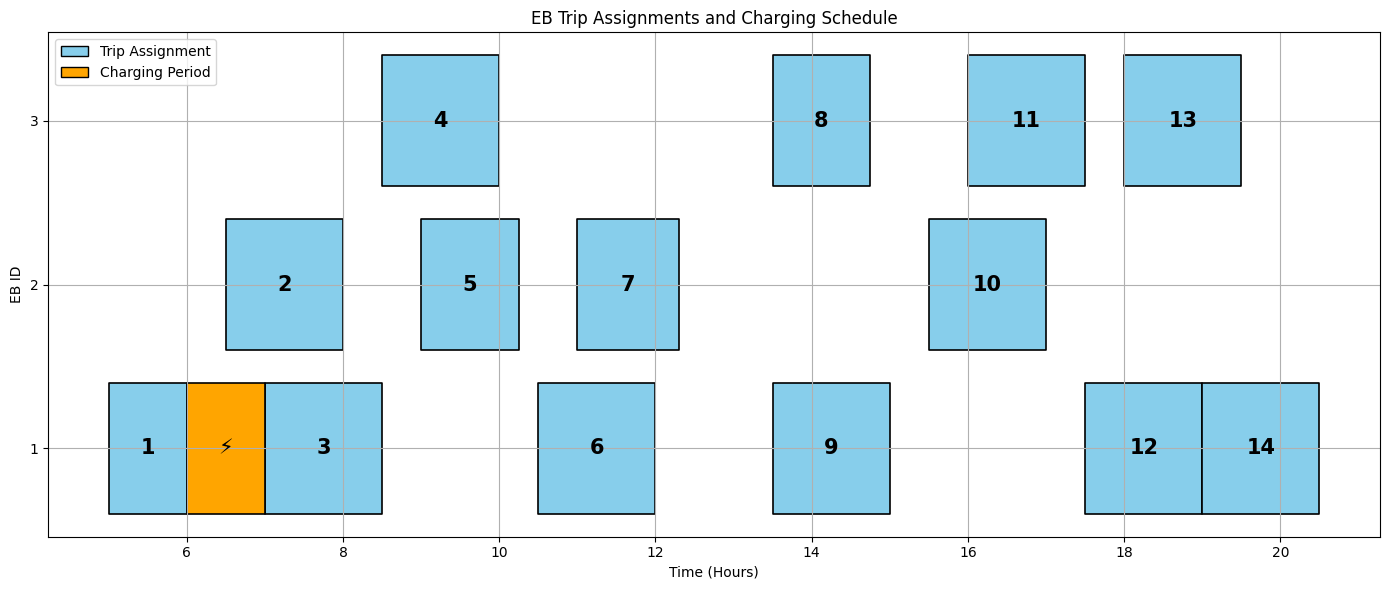

<Figure size 640x480 with 0 Axes>

In [ ]:
# Re-run the plotting with border lines and a legend (key)

import matplotlib.pyplot as plt
import pandas as pd

# Revised trip start times in HH:MM.SS format
trip_start_times_raw = {
    1: "5:00.00", 2: "6:30.00", 3: "7:00.00", 4: "8:30.00", 5: "9:00.00", 6: "10:30.00",
    7: "11:00.00", 8: "13:30.00", 9: "13:30.00", 10: "15:30.00", 11: "16:00.00", 12: "17:30.00",
    13: "18:00.00", 14: "19:00.00"
}
trip_end_times_raw = {
    1: "6:00.00", 2: "8:00.00", 3: "8:30.00", 4: "10:00.00", 5: "10:15.00", 6: "12:00.00",
    7: "12:30.00", 8: "14:45.00", 9: "15:00.00", 10: "17:00.00", 11: "17:30.00", 12: "19:00.00",
    13: "19:30.00", 14: "20:30.00"
}
trip_duration = {1: 60, 2: 90, 3: 90, 4: 90, 5: 75, 6: 90, 7: 78, 8: 75, 9: 90, 10: 90, 11: 90, 12: 90, 13: 90, 14: 90}

# Time conversion
def time_str_to_decimal(time_str):
    hh, mm_ss = time_str.split(':')
    if '.' in mm_ss:
        mm, ss = mm_ss.split('.')
    else:
        mm, ss = mm_ss, '0'
    return int(hh) + int(mm) / 60 + int(ss) / 3600

trip_start_timez = {i: time_str_to_decimal(t) for i, t in trip_start_times_raw.items()}
trip_end_timez = {i: time_str_to_decimal(t) for i, t in trip_end_times_raw.items()}

trip_duration = {i: trip_duration[i] / 60 for i in trip_times}
charge_duration = 1 # 1 hour

# Assignments
assigned_buses = {
    (1, 1): 1, (2, 2): 1, (3, 1): 1, (4, 3): 1,
    (5, 2): 1, (6, 1): 1, (7, 2): 1, (8, 3): 1,
    (9, 1): 1, (10, 2): 1, (11, 3): 1, (12, 1): 1,
    (13, 3): 1, (14, 1): 1
}

is_charging = {(1,1):1}

# Event preparation
events = []

for (i, k), v in assigned_buses.items():
    if v == 1:
        events.append({
            'Bus': k,
            'Start': trip_start_timez[i],
            'Duration': trip_duration[i],
            'Label': str(i),
            'Color': 'skyblue',
            'Type': 'Trip'
        })

for (i, k), v in is_charging.items():
    if v == 1:
        events.append({
            'Bus': k,
            'Start': trip_end_timez[i],
            'Duration': charge_duration,
            'Label': '⚡',
            'Color': 'orange',
            'Type': 'Charge'
        })

df = pd.DataFrame(events)

# Plotting
fig, ax = plt.subplots(figsize=(14, 6))

for _, row in df.iterrows():
    ax.broken_barh([(row['Start'], row['Duration'])],
                   (row['Bus'] - 0.4, 0.8),
                   facecolors=row['Color'],
                   edgecolors='black',
                   linewidth=1.2)

    x_center = row['Start'] + row['Duration'] / 2
    ax.text(x_center, row['Bus'], row['Label'],
            va='center', ha='center', fontsize=15, weight='bold')

ax.set_xlabel("Time (Hours)")
ax.set_ylabel("EB ID")
ax.set_yticks(sorted(df['Bus'].unique()))
ax.set_title("EB Trip Assignments and Charging Schedule")
ax.grid(True)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='skyblue', edgecolor='black', label='Trip Assignment'),
    Patch(facecolor='orange', edgecolor='black', label='Charging Period')
]
ax.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()

# Add a legend manually
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='skyblue', edgecolor='black', label='Trip Assignment'),
    Patch(facecolor='orange', edgecolor='black', label='Charging Period')
]
ax.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()


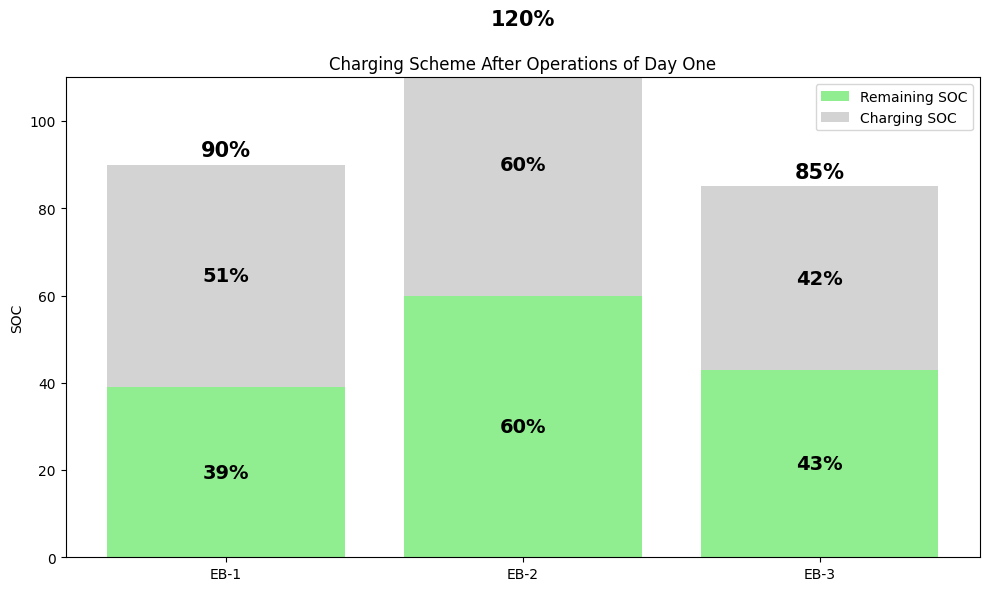

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
bus_labels = ['EB-1', 'EB-2', 'EB-3']
remaining_soc = [39, 60, 43]
charging_soc = [51, 60, 42]

# Compute total SOC
total_soc = [r + c for r, c in zip(remaining_soc, charging_soc)]

# Set up bar positions
x = np.arange(len(bus_labels))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bottom bars (remaining SOC)
bars1 = ax.bar(x, remaining_soc, color='lightgreen', label='Remaining SOC')

# Plot top bars (charging SOC)
bars2 = ax.bar(x, charging_soc, bottom=remaining_soc, color='lightgray', label='Charging SOC')

# Add percentage labels
for i in range(len(x)):
    ax.text(x[i], remaining_soc[i]/2, f"{remaining_soc[i]}%", ha='center', va='center', fontsize=14,weight='bold')
    ax.text(x[i], remaining_soc[i] + charging_soc[i]/2, f"{charging_soc[i]}%", ha='center', va='center', fontsize=14,weight='bold')
    ax.text(x[i], total_soc[i] + 2, f"{total_soc[i]}%", ha='center', fontsize=15, weight='bold')

# Customize axes
ax.set_xticks(x)
ax.set_xticklabels(bus_labels)
ax.set_ylim(0, 110)
ax.set_ylabel("SOC")
ax.set_title("Charging Scheme After Operations of Day One")
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


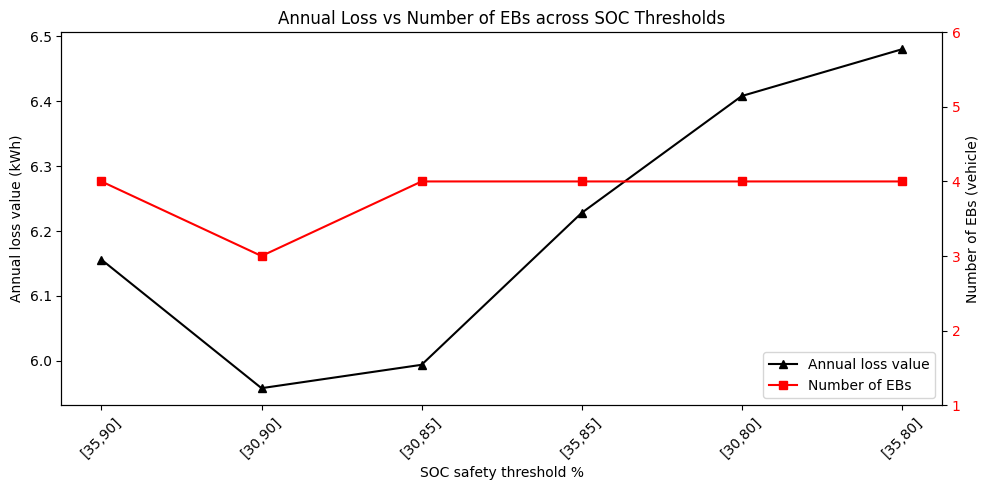

In [ ]:
import matplotlib.pyplot as plt

# Sample data
soc_thresholds = [
    "[35,90]", "[30,90]", "[30,85]", "[35,85]", "[30,80]", "[35,80]"]
annual_loss = [6.156, 5.958, 5.994, 6.228, 6.408, 6.48]
num_ebs =     [4,     3,     4,     4,     4,     4]

x = range(len(soc_thresholds))

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot annual loss value (left Y-axis)
ax1.plot(x, annual_loss, color='black', marker='^', label='Annual loss value')
ax1.set_xlabel('SOC safety threshold %')
ax1.set_ylabel('Annual loss value (kWh)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticks(x)
ax1.set_xticklabels(soc_thresholds, rotation=45)

# Plot number of EBs (right Y-axis)
ax2 = ax1.twinx()
ax2.plot(x, num_ebs, color='red', marker='s', label='Number of EBs')
ax2.set_ylabel('Number of EBs (vehicle)', color='black')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(1, 6)

# Legends
lns1 = ax1.get_lines()[0]
lns2 = ax2.get_lines()[0]
ax1.legend([lns1, lns2], ['Annual loss value', 'Number of EBs'], loc='lower right')

plt.title("Annual Loss vs Number of EBs across SOC Thresholds")
plt.tight_layout()
plt.show()


In [ ]:
import pyomo.environ as py



# Create a concrete model
model = py.ConcreteModel()


num_of_buses = 5
# Define the sets of trips and buses using Set instead of RangeSet
model.trips = py.Set(initialize=range(1, num_of_trips + 1))
model.buses = py.Set(initialize=range(1, num_of_buses + 1))
model.days = py.Set(initialize=range(1, 11))


#Define Parameters (These will be fine tuned to get the lowest battery degradation)
model.T_start = py.Param(model.trips, initialize=trip_start_times)
model.T_end = py.Param(model.trips, initialize=trip_end_times)
model.T_trip = py.Param(model.trips, initialize=trip_times)
model.lambda_min = py.Param(initialize=30)
model.lambda_max = py.Param(initialize=90)
model.CB = py.Param(initialize=282)
model.EC = py.Param(model.trips, initialize=energy_consumption)
model.E_all = py.Param(model.days, initialize=next_day_energy_demand)
model.gamma1 = py.Param(initialize=gamma_1)
model.gamma2 = py.Param(initialize=gamma_2)
model.gamma3 = py.Param(initialize=gamma_3)
model.gamma4 = py.Param(initialize=gamma_4)
model.N_min = py.Param(initialize=3)  # Set actual lower bound
model.N_max = py.Param(initialize=5)  # Set actual upper bound


# Define Decision Variables

model.assigned_buses = py.Var(model.trips, model.buses, domain=py.Binary)
model.is_charging = py.Var(model.trips, model.buses, domain=py.Binary)
model.SOC = py.Var(model.trips,model.buses)
model.E_charge_total = py.Var(domain=py.NonNegativeReals)
model.E_rest = py.Var(within=py.NonNegativeReals)



for k in range(1, num_of_buses + 1):
  if k ==1:
    model.SOC[1, k].fix(90)
  elif k == 2:
    model.SOC[1, k].fix(90)
  elif k ==3:
    model.SOC[1,k].fix(90)
  else:
    model.SOC[1,k].fix(90)
#model.SOC[6,1].fix(model.lambda_max) #for 100
model.assigned_buses[12,3].fix(1.0) #for 4 buses
model.assigned_buses[13,4].fix(1.0) #for 4 buses
#model.assigned_buses[13,2].fix(1.0) #for 3 buses






# Define Constraints
#Constraint 1
def one_bus_per_trip_rule(model, i):
  "This constraint ensures that each trip is assigned to exactly one bus"

  return sum(model.assigned_buses[i, k] for k in model.buses) == 1

model.one_bus_per_trip = py.Constraint(model.trips, rule=one_bus_per_trip_rule)

#Constraint 2

"Created sets of valid trip pairs(tuples) that each bus can make. Created a set of the second trip in the tuple also. The set of the second trip is to track whether the second trip of one tuple can be followed by the first trip of another tuple "
valid_trips_per_bus = {k: set() for k in range(1, num_of_buses + 1)}
value_j_per_bus = {k: set() for k in range(1, num_of_buses + 1)}

def update_valid_trips(k):

  """Update the set of valid trips for a specific bus"""

  valid_trip_pairs = set()
  value_j = set()
  for i in model.trips:
    for j in model.trips:
        if j > i and (model.T_start[j] - model.T_end[i] >= model.T_trip[i]):
          if i % 2 != 0 and (j % 2 == 0) and j != len(model.trips) and i != 1:
            valid_trip_pairs.add((i,j))
            value_j.add(j)
          elif i % 2 == 0 and (j % 2 != 0 or j == len(model.trips)):
            valid_trip_pairs.add((i,j))
            value_j.add(j)
          elif i == 1 and (j % 2 != 0 or j == len(model.trips)):
            valid_trip_pairs.add((i,j))
            value_j.add(j)

  valid_trips_per_bus[k] = valid_trip_pairs
  value_j_per_bus[k] = value_j

def remove_assigned_pair(i, j):

  "Removes all instances of a trip pair from all valip trip pairs sets for each bus"

  tup = (i,j)
  for k in valid_trips_per_bus:
    valid_trips_per_bus[k].discard(tup)

def remove_j(j):

  "Removes all instances of the second trip in a tuple from all sets for each bus "

  for k in valid_trips_per_bus:
    value_j_per_bus[k].discard(j)

for i in range(1, len(model.trips)+1):
  update_valid_trips(i)
print(valid_trips_per_bus[1])
print(value_j_per_bus[1])
def trip_time_interval_rule(model,i,j,k):

  "Ensures there is enough time to charge and any other miscelleneous activities between trips for each bus. This constraint determines the charging and operating schedule of the buses"

  if j > i and (model.T_start[j] - model.T_end[i] >= model.T_trip[i]):
    tup = (i,j)

    if tup in valid_trips_per_bus[k]: #checks if trip pair(tuple) is in the possible valid trip pairs
        possible_j = []

        for (x,y) in valid_trips_per_bus[k]:
          if x == i:
            possible_j.append(y)
        min_j = min(possible_j)
        if tup[1] == min_j and tup[0] == i: # checks if the tuple is (i,min_j)
          if (j-i) != 1:                    # checks if the trips are consecutive or not
            for num in range(i+1,j):
              for num_j in range(1,len(model.trips) + 1):
                tup = (num,num_j)
                valid_trips_per_bus[k].discard(tup)             #if not consecutive removes all trip pairs between i and min_j for that bus so that cannot be consider for assignment
                if num == j:
                  for n in (1,len(model.buses) + 1):
                    if k != n:
                      valid_trips_per_bus[k].discard(tup)

          #print(i,j)
          removed_pairs = []
          for (x,y) in valid_trips_per_bus[k]:
            if x == i and y > min_j:
              removed_pairs.append((x,y))
          for (x,y) in removed_pairs:
            remove_assigned_pair(x,y)


          print(i,j,k)
          remove_assigned_pair(i,j)               # remove trip pair from all valid trip pairs of all buses and assign the trip to bus k
          return model.assigned_buses[i, k] == 1
        else:
          return py.Constraint.Skip
    else:
      return py.Constraint.Skip
  else:
    return py.Constraint.Skip

model.trip_time_interval = py.Constraint(model.trips, model.trips, model.buses,rule=trip_time_interval_rule)

#Constraint 3
def soc_between_trips_rule(model, i, k):

  "This constraint tracks the SOC value of the buses as they discharge and charge"

  if i == 1:
    return model.SOC[i+1, k] == (model.SOC[i, k] - (round((model.EC[i] / model.CB),2) * 100 * model.assigned_buses[i, k]))
  elif i % 2 != 0:
    return model.SOC[i,k] == (model.SOC[i-1,k] - (round((model.EC[i-1] / model.CB),2) * 100 * model.assigned_buses[i-1, k])) + ((model.lambda_max - model.SOC[i-1, k])* model.is_charging[i-1,k])
  else:
    return model.SOC[i,k] == (model.SOC[i-1,k] - (round((model.EC[i-1] / model.CB),2) * 100 * model.assigned_buses[i-1, k]))
model.soc_between = py.Constraint(model.trips, model.buses, rule=soc_between_trips_rule)

#Constraint 4.1
def max_simultaneous_charging_rule(model, i):

  "This constraint sets a maximum number of buses that can charge at the same time"

  return sum(model.is_charging[i, k] for k in model.buses) <= 2

model.max_simultaneous_charging = py.Constraint(model.trips, rule=max_simultaneous_charging_rule)

#Constraint 4.2
def soc_charging_rule(model, i, k):

  "This constraint ensures that a bus is in a charging state when its SOC falls below 25 if it is to go for the next trip"

  return model.is_charging[i, k] >= (model.lambda_min - model.SOC[i, k]) / model.lambda_min

model.soc_charging = py.Constraint(model.trips, model.buses, rule=soc_charging_rule)

#Constraint 4.3
def no_assignment_while_charging_rule(model, i, k):

  "This constraint ensures that a bus cannot be assigned to a trip while it is charging"

  return model.assigned_buses[i, k] + model.is_charging[i, k] <= 1

model.no_assignment_while_charging = py.Constraint(model.trips, model.buses, rule=no_assignment_while_charging_rule)

#Constraint 5
def soc_minimum_rule(model, i, k):
  "This constraint ensures that the buses do not fall below the minimum operational SOC"

  return model.SOC[i, k] >= model.lambda_min

model.soc_minimum = py.Constraint(model.trips, model.buses, rule=soc_minimum_rule)

#Constraint 6.1
def remaining_energy_rule(model):
  "This constraint finds out the remaining charge of the remaining battery power of the buses after completing the full day of operations in kWh."

  return model.E_rest == sum((model.SOC[len(model.trips), k] * model.CB)/100 for k in model.buses)

model.remaining_energy_const = py.Constraint(rule=remaining_energy_rule)

#Constraint 6.2
def min_total_charge_rule(model):
  "This constraint finds the minimum total charge for each bus for the next day's operation"

  return model.E_charge_total == ((model.E_all[1] + (len(model.buses) * model.CB * model.lambda_min * 0.01) - model.E_rest)) / len(model.buses)

model.min_total_charge_const = py.Constraint(rule=min_total_charge_rule)



# Binary variable indicating whether bus k is used
model.bus_used = py.Var(model.buses, domain=py.Binary)

# Constraint: A bus must be marked as used if any trip is assigned to it
def bus_used_link_rule(model, k):
    return sum(model.assigned_buses[i, k] for i in model.trips) <= len(model.trips) * model.bus_used[k]

model.bus_used_link = py.Constraint(model.buses, rule=bus_used_link_rule)

# Constraint: Number of buses used must be between 3 and 5
def bus_count_bounds_rule1(model):
    return model.N_min <= sum(model.bus_used[k] for k in model.buses)

model.bus_count_bounds1 = py.Constraint(rule=bus_count_bounds_rule1)

def bus_count_bounds_rule2(model):
    return model.N_max >= sum(model.bus_used[k] for k in model.buses)

model.bus_count_bounds2 = py.Constraint(rule=bus_count_bounds_rule2)

def assignment_limited_to_active_buses(model, i, k):
    return model.assigned_buses[i, k] <= model.bus_used[k]

model.bus_assignment_activation = py.Constraint(model.trips, model.buses, rule=assignment_limited_to_active_buses)



#Objective Function
alpha = 0.5  # weight for degradation
beta = 0.5   # weight for bus count
def battery_degradation_objective(model):
    degradation = 0
    for k in model.buses:
        for i in model.trips:
            if i != max(model.trips) :  # Check if it's not the last trip
                SOC_avg = (model.SOC[i, k] + model.SOC[i + 1, k])*0.5*0.01
                SOC_dev = model.SOC[i, k]*0.01 - SOC_avg
                term = (model.gamma1 * SOC_dev * py.exp(model.gamma2 * SOC_avg) +model.gamma3 * py.exp(model.gamma4 * SOC_dev)) * abs((model.SOC[i, k] - model.SOC[i + 1, k])) * model.CB *0.01
            else:  # For the last trip, assume no discharging occurs
                term = 0
            # Add both components to total degradation
            degradation += term
    for k in model.buses:
      SOC_avg_last = (model.SOC[len(model.trips), k] + model.lambda_max) *0.5 *0.01
      SOC_dev_last = model.SOC[len(model.trips), k] *0.01 - SOC_avg
      term = ( model.gamma1 * SOC_dev * py.exp(model.gamma2 * SOC_avg) + model.gamma3 * py.exp(model.gamma4 * SOC_dev))* model.E_charge_total
      degradation += term
    return alpha * degradation + beta * sum(model.bus_used[k] for k in model.buses)
    #return degradation

model.objective = py.Objective(rule=battery_degradation_objective, sense=py.minimize)






{(4, 9), (3, 10), (5, 10), (2, 11), (1, 3), (1, 9), (2, 14), (6, 11), (7, 10), (6, 14), (3, 6), (3, 12), (4, 14), (4, 11), (5, 12), (8, 11), (8, 14), (2, 7), (1, 5), (1, 11), (10, 14), (1, 14), (2, 13), (6, 13), (7, 12), (3, 8), (4, 13), (5, 8), (9, 12), (8, 13), (2, 9), (1, 7), (1, 13), (6, 9)}
{3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
1 3 1
2 7 2
3 6 1
4 9 3
5 8 4
6 9 1
7 10 2
8 11 4
9 12 1
10 14 2


In [ ]:
from pyomo.opt import SolverFactory

# Create and run the solver

solver = SolverFactory(modules.find("gurobi"))
results = solver.solve(model, tee=True)

# Check solution status
def print_solver_status():
    print("\n=== Solver Status ===")
    print(f"Termination condition: {results.solver.termination_condition}")
    print(f"Status: {results.solver.status}")

    if results.solver.termination_condition == 'optimal':
        print("\n=== Optimal Solution Found ===")
        print(f"\nBattery Degradation Objective: {py.value(model.objective):.4f}")
        #print(f"\nBattery Degradation Objective: {py.value(model.degradation):.4f}")


        # Print bus assignments
        print("\nBus Assignments:")
        for i in model.trips:
            for k in model.buses:
                if py.value(model.assigned_buses[i,k]) == 1 :  # Using 0.9 threshold for binary variables
                    print(f"Trip {i} assigned to Bus {k}")

        print("This is the total charge remaining for the buses ",round(py.value(model.E_charge_total)),"kwH")
        print(model.E_all[1])

    else:
        print("\nNo optimal solution found.")
        print("Check model constraints and parameters.")

# Call the function to display results
print_solver_status()

Gurobi 12.0.1: 
=== Solver Status ===
Termination condition: optimal
Status: ok

=== Optimal Solution Found ===

Battery Degradation Objective: 2.0044

Bus Assignments:
Trip 1 assigned to Bus 1
Trip 2 assigned to Bus 2
Trip 3 assigned to Bus 1
Trip 4 assigned to Bus 3
Trip 5 assigned to Bus 4
Trip 6 assigned to Bus 1
Trip 7 assigned to Bus 2
Trip 8 assigned to Bus 4
Trip 9 assigned to Bus 1
Trip 10 assigned to Bus 2
Trip 11 assigned to Bus 4
Trip 12 assigned to Bus 3
Trip 13 assigned to Bus 4
Trip 14 assigned to Bus 3
This is the total charge remaining for the buses  27 kwH
508.1


In [ ]:
model.pprint()

3 Set Declarations
    buses : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    4 : {1, 2, 3, 4}
    days : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
    trips : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   14 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

14 Param Declarations
    CB : Size=1, Index=None, Domain=Any, Default=None, Mutable=False
        Key  : Value
        None :   282
    EC : Size=14, Index=trips, Domain=Any, Default=None, Mutable=False
        Key : Value
          1 :  42.3
          2 :  42.2
          3 :  33.2
          4 :  37.1
          5 :  32.7
          6 :  31.5
          7 :  33.6
          8 :  31.8
          9 :  33.4
         10 :  31.4
         11 :  42.9
         12 :  45.1
         13 :  4